<a href="https://colab.research.google.com/github/norhum/reinforcement-learning-from-scratch/blob/main/lecture5_A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducing Actor-Critic Methods and A2C

As discussed, basic REINFORCE suffers from high variance due to its reliance on full-episode returns. **Actor-Critic** methods aim to mitigate this by learning both a policy (the **Actor**) and a state-value function (the **Critic**) simultaneously.

*   **Critic:** Learns V(s), the expected return from state *s* under the current policy. Provides a baseline estimate of how good a state is.
*   **Actor:** Learns the policy π(a|s). Instead of being updated by the noisy full return *G<sub>t</sub>*, it's updated using the **Advantage function**, often estimated as *A(s, a) ≈ R + γV(s') - V(s)*. This advantage signal measures how much better action *a* performed compared to the expected value of state *s*, resulting in lower variance updates.

We'll implement **Advantage Actor-Critic (A2C)**, a common synchronous variant.

### The Pendulum Environment

We need a new challenge, particularly one with **continuous actions**, where Policy Gradients shine. We'll use Gymnasium's **Pendulum-v1** environment.

https://gymnasium.farama.org/environments/classic_control/pendulum/

*   **Goal:** Swing a pendulum up and keep it balanced upright.
*   **State Space (Continuous):** 3 values: `[cos(theta), sin(theta), angular_velocity]`. `theta` is the angle from upright (0).
*   **Action Space (Continuous):** A single value representing the torque applied to the pendulum, typically bounded between [-2.0, +2.0].
*   **Reward:** A complex function based on angle, angular velocity, and torque applied. It's usually negative, with 0 being the best possible reward (perfectly upright, no velocity, no torque). The goal is to maximize this (i.e., get it as close to 0 as possible).

Since the action is continuous, the Actor network won't output probabilities for discrete actions. Instead, it will output the parameters of a probability distribution over the continuous action space. A common choice is the **Normal (Gaussian) distribution**. The Actor will output the *mean* (μ) and *standard deviation* (σ) for the torque, and we'll *sample* the actual torque action from *N(μ, σ)*.

### Implementing A2C for Pendulum

Let's start building the components: the Actor network, the Critic network, and the A2CAgent class.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal # Import Normal distribution class
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

#### The Actor Network

Outputs parameters (mean and std dev) for the Normal distribution over actions.

In [2]:
class Actor(nn.Module):
    def __init__(self, state_size, hidden_size, action_bound):
        super().__init__()
        self.state_size = state_size
        self.hidden_size = hidden_size
        # Store action bound for scaling the mean output
        self._action_bound = action_bound

        # Network layers
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Layer to output the mean of the action distribution
        self.fc_actor_mean = nn.Linear(hidden_size, 1) # Pendulum has 1D action

        # Learnable parameter for log standard deviation
        # Initialized near zero, so initial std is near 1.0
        self.actor_log_std = nn.Parameter(torch.zeros(1))

    def forward(self, state):
        # Move state to device if not already there
        state = state.to(device)

        # Pass through shared layers
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # Calculate mean, clamping with tanh and scaling by action_bound
        mean = torch.tanh(self.fc_actor_mean(x)) * self._action_bound

        # Calculate std dev from log_std, ensuring positivity with exp()
        # Expand log_std to match the shape of mean for broadcasting
        log_std = self.actor_log_std.expand_as(mean)
        std = torch.exp(log_std)

        # Return mean and standard deviation
        return mean, std

    def get_action(self, state, deterministic=False):
        # Ensure state is a tensor and has batch dimension if needed
        if isinstance(state, np.ndarray): # Convert numpy state if needed
             state = torch.tensor(state, dtype=torch.float32)
        if state.dim() == 1:
             state = state.unsqueeze(0) # Add batch dimension if single state
        state = state.to(device)

        with torch.no_grad(): # No gradients needed for action selection
            mean, std = self.forward(state)
            # Create Normal distribution object
            normal_dist = Normal(mean, std)
            if deterministic:
                # For evaluation, typically use the mean
                action = mean
            else:
                # During training, sample from the distribution
                action = normal_dist.sample()

        # Remove batch dimension before returning (assuming single action needed)
        # Clamp action to be within environment bounds (important for some envs)
        action = torch.clamp(action, -self._action_bound, self._action_bound)
        return action.squeeze(0) # Remove batch dim

#### The Critic Network

Takes a state and outputs a single value V(s).

In [3]:
class Critic(nn.Module):
    def __init__(self, state_size, hidden_size):
        super().__init__()
        self.state_size = state_size
        self.hidden_size = hidden_size

        # Network layers
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Layer to output the single state value
        self.fc_critic = nn.Linear(hidden_size, 1)

    def forward(self, state):
        # Move state to device if not already there
        state = state.to(device)

        # Pass through layers
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # Output the estimated state value
        value = self.fc_critic(x)

        return value

#### The `A2CAgent` Class

Combines the Actor and Critic networks and implements the training step.

In [4]:
class A2CAgent:
    def __init__(self, state_size, hidden_size, action_bound, actor_lr=1e-4, critic_lr=5e-4, gamma=0.99, entropy_coef=0.01):
        self.gamma = gamma
        self.entropy_coef = entropy_coef

        # Instantiate Actor and Critic networks
        self.actor = Actor(state_size, hidden_size, action_bound).to(device)
        self.critic = Critic(state_size, hidden_size).to(device)

        # Separate optimizers for Actor and Critic
        self.optimizer_actor = optim.AdamW(self.actor.parameters(), lr=actor_lr)
        self.optimizer_critic = optim.AdamW(self.critic.parameters(), lr=critic_lr)

    def train_step(self, states, actions, rewards, next_states, dones):
        # Convert lists of tensors/numbers into batch tensors
        states = torch.stack(states).to(device)
        actions = torch.stack(actions).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
        next_states = torch.stack(next_states).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device) # Use float for multiplication

        # --- Critic Update ---
        # Get current state values V(S) and next state values V(S') from Critic
        values = self.critic(states)
        with torch.no_grad(): # Target calculation should not affect critic gradients via next_values
             next_values = self.critic(next_states)
        # Calculate TD Target: R + gamma * V(S') * (1 - done)
        td_targets = rewards + self.gamma * next_values * (1.0 - dones) # Ensure float multiplication
        # Calculate Critic Loss (MSE between V(S) and TD Target)
        critic_loss = F.mse_loss(values, td_targets.detach()) # Detach targets

        # Update Critic
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        # --- Actor Update ---
        # Calculate Advantages: A(S, A) = TD Target - V(S)
        with torch.no_grad(): # Advantages calculation should not affect actor gradients via values
             advantages = td_targets - values # Shape [batch_size, 1]
             # Normalize advantages (optional but recommended)
             advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Get action distribution parameters (mean, std) from Actor for the batch states
        means, stds = self.actor(states)
        # Create Normal distribution
        dist = Normal(means, stds)
        # Calculate log probability of the actions actually taken: log(pi(A|S))
        log_probs = dist.log_prob(actions)

        # Calculate Policy Gradient Loss: - mean(log_probs * advantages)
        policy_loss = -(log_probs * advantages_normalized.detach()).mean() # Detach advantages

        # Calculate Entropy Bonus
        # Entropy encourages exploration by penalizing overly confident policies
        entropy = dist.entropy().mean()
        # We *subtract* entropy * coefficient from the loss to encourage higher entropy
        actor_loss = policy_loss - self.entropy_coef * entropy

        # Update Actor
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

        # Return losses and entropy for monitoring
        return actor_loss.item(), critic_loss.item(), entropy.item()

#### Understanding `A2CAgent`:

*   **`__init__`**: Stores hyperparameters (`gamma`, `entropy_coef`). Instantiates separate `Actor` and `Critic` networks. Creates separate `AdamW` optimizers for each network. No replay buffer is used, as A2C is typically on-policy.
*   **`train_step`**: Performs a single update step using a batch of transitions.
    *   **Critic Update:**
        *   Gets state values `V(S)` and `V(S')` from the `critic` network.
        *   Calculates the TD targets `R + gamma * V(S') * (1 - done)`. `next_values` are detached to prevent gradients flowing back from the target calculation.
        *   Computes the `critic_loss` (MSE between `V(S)` and the detached TD targets).
        *   Updates the `critic` network using its optimizer.
    *   **Actor Update:**
        *   Calculates `advantages` (TD Target - `V(S)`). `values` are detached so critic gradients don't influence actor update. Advantages are typically normalized.
        *   Gets the action distribution (`dist`) from the `actor` network for the batch `states`.
        *   Calculates `log_probs` of the `actions` taken under this distribution.
        *   Calculates `policy_loss` as `- mean(log_probs * detached_normalized_advantages)`. Detaching advantages ensures the update only follows the policy gradient, not the value gradient.
        *   Calculates the distribution's `entropy`.
        *   Calculates the final `actor_loss` including the entropy bonus (subtracting `entropy_coef * entropy` encourages higher entropy/exploration).
        *   Updates the `actor` network using its optimizer.

### Training the A2C Agent on Pendulum

Now, the main training loop function that collects batches of experience and calls `agent.train_step`.

Using device: cuda
Starting A2C Training for 3000 episodes...
Ep   100 | Steps   20000 | Avg Rwd (last 100 ep): -1566.5 | Best Avg Rwd: -1452.6 | Avg A_Loss: -0.0616 | Avg C_Loss:  0.2728 | Entropy: 1.4135
Ep   200 | Steps   40000 | Avg Rwd (last 100 ep): -1398.5 | Best Avg Rwd: -1396.0 | Avg A_Loss: -0.0193 | Avg C_Loss:  0.4544 | Entropy: 1.4080
Ep   300 | Steps   60000 | Avg Rwd (last 100 ep): -1481.0 | Best Avg Rwd: -1381.0 | Avg A_Loss: -0.0538 | Avg C_Loss:  0.2340 | Entropy: 1.4053
Ep   400 | Steps   80000 | Avg Rwd (last 100 ep): -1417.5 | Best Avg Rwd: -1381.0 | Avg A_Loss: -0.0758 | Avg C_Loss:  0.4112 | Entropy: 1.3934
Ep   500 | Steps  100000 | Avg Rwd (last 100 ep): -1337.0 | Best Avg Rwd: -1311.5 | Avg A_Loss: -0.0180 | Avg C_Loss:  1.2879 | Entropy: 1.3887
Ep   600 | Steps  120000 | Avg Rwd (last 100 ep): -1440.0 | Best Avg Rwd: -1311.5 | Avg A_Loss: -0.0245 | Avg C_Loss:  0.4828 | Entropy: 1.3857
Ep   700 | Steps  140000 | Avg Rwd (last 100 ep): -1434.1 | Best Avg Rwd: 

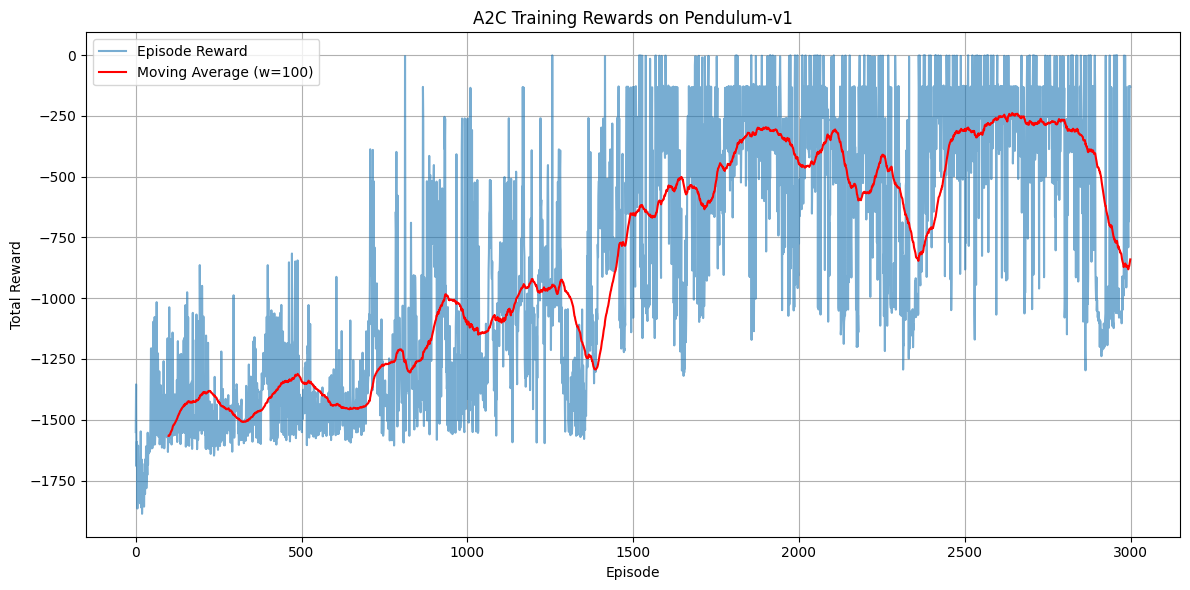

In [5]:
def train_agent_a2c(
    episodes=3000,
    batch_size=32, # Collect this many steps before updating
    hidden_size=128,
    actor_lr=1e-4,
    critic_lr=5e-4,
    gamma=0.99,
    print_every=100,
    entropy_coef=0.005,
    save_actor_filename="a2c_pendulum_actor_best.pth",
    save_critic_filename="a2c_pendulum_critic_best.pth"
    ):

    # Create Pendulum environment
    env = gym.make('Pendulum-v1')
    state_size = env.observation_space.shape[0]
    # Action is continuous, get bound for scaling actor output
    action_bound = env.action_space.high[0]

    # Instantiate the A2C agent
    agent = A2CAgent(
        state_size=state_size, hidden_size=hidden_size, action_bound=action_bound,
        actor_lr=actor_lr, critic_lr=critic_lr, gamma=gamma, entropy_coef=entropy_coef
    )

    # Logging lists
    episode_rewards = [] # Store raw reward per episode
    # Temporary lists to hold batch data
    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = [], [], [], [], []
    # Lists to store losses/entropy between logging prints
    update_actor_losses, update_critic_losses, update_entropies= [], [], []

    best_avg_reward = -float('inf') # Track best average reward for saving model
    total_steps = 0 # Track total environment steps

    print(f"Starting A2C Training for {episodes} episodes...")

    for episode in range(episodes):
        # Reset environment and get initial state tensor
        state_np, info = env.reset() # Using seed from provided code: seed=42 + episode
        state = torch.tensor(state_np, dtype=torch.float32).to(device)
        episode_reward_raw = 0 # Track raw reward for this episode

        # Episode loop (no fixed step limit, runs until done)
        while True:
            # Agent selects action (tensor) based on state
            action_tensor = agent.actor.get_action(state)
            # Convert action tensor to numpy for environment step
            action_np = action_tensor.cpu().numpy() # Env expects numpy

            # Step environment
            next_state_np, reward_raw, terminated, truncated, info = env.step(action_np)
            done = terminated or truncated # Episode ends if terminated or truncated
            total_steps += 1

            # --- Reward Scaling ---
            # Pendulum rewards are roughly -16 to 0. Scale to approx -1 to 0 or 0 to 1.
            # Original code scales to (-16+8)/8 = -1 to (0+8)/8 = 1 range. Let's use that.
            # Neural networks train more stably with smaller, centered, or positive targets.
            # Scaling shifts the range (e.g. to [-1, 1] or [0, 1]) making targets more manageable
            # for the critic and improving stability of advantage calculation for the actor.
            reward_normalized = (reward_raw + 8.0) / 8.0 # Scale reward

            # Convert next state to tensor
            next_state = torch.tensor(next_state_np, dtype=torch.float32).to(device)

            # Store transition in temporary batch lists
            batch_states.append(state)
            batch_actions.append(action_tensor)
            batch_rewards.append(reward_normalized)
            batch_next_states.append(next_state)
            batch_dones.append(done) # Store boolean done flag

            state = next_state # Update state for next iteration
            episode_reward_raw += reward_raw # Accumulate raw reward for logging

            # --- Train if batch is full ---
            if len(batch_states) >= batch_size:
                actor_loss, critic_loss, entropy = agent.train_step(
                    batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones
                )
                # Log losses for averaging later
                update_actor_losses.append(actor_loss)
                update_critic_losses.append(critic_loss)
                update_entropies.append(entropy)

                # Clear batch lists
                batch_states.clear(); batch_actions.clear(); batch_rewards.clear(); batch_next_states.clear(); batch_dones.clear()

            # Check if episode ended
            if done:
                # --- Train on remaining data if episode ends before batch is full ---
                if batch_states: # Check if there's anything left in the batch
                    actor_loss, critic_loss, entropy = agent.train_step(
                         batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones
                    )
                    # Log losses from this final partial batch update
                    update_actor_losses.append(actor_loss)
                    update_critic_losses.append(critic_loss)
                    update_entropies.append(entropy)
                    # Clear lists (although loop ends anyway)
                    batch_states.clear(); batch_actions.clear(); batch_rewards.clear(); batch_next_states.clear(); batch_dones.clear()
                break # Exit the episode loop

        # --- End of Episode ---
        episode_rewards.append(episode_reward_raw) # Log raw reward for performance tracking

        # Calculate average reward for saving best model (using raw rewards)
        # Use a window size matching print_every for consistency
        if len(episode_rewards) >= print_every:
            avg_reward_raw = np.mean(episode_rewards[-print_every:])
        else:
            # Calculate average over however many episodes have run so far
            avg_reward_raw = np.mean(episode_rewards) if episode_rewards else -float('inf')

        # Save best model based on average raw reward
        if avg_reward_raw > best_avg_reward:
            best_avg_reward = avg_reward_raw
            torch.save(agent.actor.state_dict(), save_actor_filename)
            torch.save(agent.critic.state_dict(), save_critic_filename)

        # Print log summary periodically
        if (episode + 1) % print_every == 0 and episode > 0:
             # Calculate average losses since last print
             avg_actor_loss = np.mean(update_actor_losses) if update_actor_losses else 0
             avg_critic_loss = np.mean(update_critic_losses) if update_critic_losses else 0
             avg_entropy = np.mean(update_entropies) if update_entropies else 0
             # Clear loss/entropy lists for the next interval
             update_actor_losses.clear(); update_critic_losses.clear(); update_entropies.clear()

             print(f"Ep {episode+1:5d} | Steps {total_steps:7d} | Avg Rwd (last {min(print_every, len(episode_rewards))} ep): {avg_reward_raw:7.1f} | "
                   f"Best Avg Rwd: {best_avg_reward:.1f} | Avg A_Loss: {avg_actor_loss:7.4f} | Avg C_Loss: {avg_critic_loss:7.4f} | Entropy: {avg_entropy:6.4f}")

    env.close()
    print(f"\nTraining finished. Best models saved to {save_actor_filename} and {save_critic_filename} with average reward: {best_avg_reward:.2f}")
    return agent, episode_rewards # Return final agent and reward history

# Plotting function
def plot_rewards(rewards, window=100):
    """Plots episode rewards with a moving average."""
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Reward', alpha=0.6)
    if len(rewards) >= window:
        moving_avg = np.convolve(np.array(rewards), np.ones(window)/window, mode='valid')
        plt.plot(np.arange(window-1, len(rewards)), moving_avg, label=f'Moving Average (w={window})', color='red')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("A2C Training Rewards on Pendulum-v1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define device (redundant if defined globally, safe otherwise)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seed for reproducibility
torch.manual_seed(42)

# Call training function
trained_agent_a2c, rewards_history_a2c = train_agent_a2c(
    episodes=3000,
    batch_size=128,
    hidden_size=256,
    actor_lr=1e-4,
    critic_lr=5e-4,
    gamma=0.99,
    print_every=100,
    entropy_coef=0.005,
    save_actor_filename="best_a2c_pendulum_actor.pth",
    save_critic_filename="best_a2c_pendulum_critic.pth"
)

# Plot the results
plot_rewards(rewards_history_a2c, window=100)

<!-- Code Cell Output: Device message, training logs showing progress (episode, steps, rewards, losses, entropy), final message, and the reward plot. -->

#### Understanding the A2C Training Loop:

*   **Initialization:** Creates the Pendulum environment, gets specs (`state_size`, `action_bound`), and initializes the `A2CAgent`. Sets up lists for logging rewards and temporary batch storage.
*   **Episode Loop:** Iterates through episodes.
    *   **Step Loop (`while True`)**: Runs until `done`.
        *   Agent gets `action_tensor` (continuous value) from the Actor.
        *   Action is converted to NumPy for `env.step`.
        *   Environment transition `(next_state_np, reward_raw, terminated, truncated)` is received.
        *   **Reward Scaling:** The `reward_raw` (often large negative) is normalized (e.g., to `[-1, 1]`) to stabilize training. *Mentioned in script: This scaling is crucial because networks struggle with large, negative targets. Raw rewards are around -16 to 0. Adding 8 shifts this to -8 to +8. Dividing by 8 scales it to -1 to +1, a much better range.*
        *   Transition data (using `reward_normalized`) is stored in `batch_` lists.
        *   **Batch Training:** If the number of stored transitions reaches `batch_size`, `agent.train_step` is called with the batch data, the networks are updated, and the batch lists are cleared.
        *   Episode ends when `done` is true. Any remaining transitions in the batch are used for a final update.
    *   **Logging & Saving:** Raw episode reward is logged. Average reward over a window is calculated. If it's the best average seen, the Actor and Critic network weights (`state_dict`) are saved. Progress is printed periodically.
*   **Return:** Returns the final agent and the history of raw episode rewards.

---

### Analyzing A2C Training Logs and Performance

Alright let's examine the training log to see how it performed.

*   **Average Reward:** The key metric. We expect to see the average raw reward (over the last `print_every` episodes) trend upwards over time, although likely staying negative (since Pendulum rewards are max 0). There will still be noise, but the trend should be clear improvement. It might dip sometimes but should generally increase.
*   **Actor Loss:** Should generally stay small and might often be negative. A negative loss here (due to the `-` sign in the policy gradient objective and the entropy term) indicates the agent is successfully increasing the probability of actions leading to positive advantages (relative to the critic's baseline) and maintaining exploration.
*   **Critic Loss:** This measures how well the Critic is predicting the state values (`V(s)`). It might *increase* significantly during training, especially when the Actor is improving rapidly. This doesn't necessarily mean the Critic is failing; it might just be struggling to keep up with the quickly changing true values of states as the policy gets better. As long as the reward improves, the Critic is likely providing a useful-enough baseline for the Actor.
*   **Entropy:** Measures the randomness/exploration of the Actor's policy (specifically, the Normal distribution it outputs). It should generally start higher (more exploration) and decrease gradually as the agent becomes more confident and the policy distribution sharpens (lower standard deviation). The `entropy_coef` prevents it from collapsing too quickly, ensuring continued exploration.

Connecting this to the rendered agent: If the logs show a good final average reward (e.g., the script mentions a peak around -275), the saved model corresponding to that peak performance should visually demonstrate effective pendulum balancing when rendered.

In [6]:
from matplotlib import animation
from IPython.display import HTML
import base64

hidden_size = 256
actor_filepath = "best_a2c_pendulum_actor.pth"
critic_filepath = "best_a2c_pendulum_critic.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

temp_env = gym.make('Pendulum-v1')
state_size = temp_env.observation_space.shape[0]
action_bound = temp_env.action_space.high[0]
temp_env.close()

best_agent = A2CAgent(state_size, hidden_size, action_bound)

best_agent.actor.load_state_dict(torch.load(actor_filepath, map_location=device))
best_agent.critic.load_state_dict(torch.load(critic_filepath, map_location=device))

best_agent.actor.to(device)
best_agent.critic.to(device)

# Create environment with rgb_array render mode instead of human
render_env = gym.make('Pendulum-v1', render_mode='rgb_array')

num_render_episodes = 3
max_steps = 200

for episode in range(num_render_episodes):
    state_np, info = render_env.reset(seed=100 + episode)
    total_reward = 0
    terminated = False
    truncated = False
    step_count = 0

    # Store frames for animation
    frames = []

    while not terminated and not truncated and step_count < max_steps:
        # Capture the frame
        frame = render_env.render()
        frames.append(frame)

        # Get action from agent
        state_tensor = torch.tensor(state_np, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            action_tensor = best_agent.actor.get_action(state_tensor, deterministic=True)

        action_np = action_tensor.cpu().numpy().flatten()

        next_state_np, reward, terminated, truncated, info = render_env.step(action_np)
        total_reward += reward
        state_np = next_state_np
        step_count += 1

    print(f"Rendered Episode {episode + 1} | Total Reward: {total_reward:.2f}")

    # Create animation from frames
    plt.figure(figsize=(frames[0].shape[1]/100, frames[0].shape[0]/100), dpi=100)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    plt.tight_layout()

    def animate(i):
        patch.set_data(frames[i])
        return [patch]

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames=len(frames), interval=20, blit=True)

    plt.close()  # Prevent display of the static figure

    # Display the animation
    display(HTML(f"<h3>Episode {episode+1} - Total Reward: {total_reward:.2f}</h3>"))
    display(HTML(anim.to_jshtml()))

render_env.close()

Rendered Episode 1 | Total Reward: -261.28


Rendered Episode 2 | Total Reward: -383.88


Rendered Episode 3 | Total Reward: -263.64




### Implementation Details and Final Thoughts on A2C

*   **Shared Networks:** The script mentions trying a shared network architecture (where Actor and Critic share initial layers) but finding separate networks worked better for this problem. This is common; the optimal architecture can be problem-dependent.
*   **Batch Updates:** Updating after collecting a small `batch_size` of experiences (rather than every single step) is crucial for A2C stability. It averages the learning signal, reducing noise compared to single-step updates. This is related to **n-step learning**, looking slightly further ahead than single-step TD but not waiting for the whole episode like Monte Carlo.
*   **Reward Scaling:** Normalizing the raw Pendulum rewards into a smaller range (like [-1, 1]) was essential for stable training, making targets more manageable for the Critic and Advantages better behaved for the Actor.
*   **On-Policy:** Remember A2C, as implemented here without a replay buffer drawing from old policies, is **on-policy**. It learns from the experiences generated by the current version of the policy.

In conclusion, our A2C agent, using separate Actor and Critic networks, batch updates, and reward scaling, successfully learned the continuous control task, showcasing the effectiveness of Actor-Critic methods in handling variance and continuous action spaces.

---

### Course Recap

And that brings us to the end of our deep dive into Reinforcement Learning fundamentals! Let's quickly recap what we covered:

*   **Multi-Armed Bandits:** Introduced the core exploration-exploitation trade-off (Epsilon-Greedy, UCB).
*   **Markov Decision Processes (MDPs):** Formalized sequential decision-making (States, Actions, Rewards, Transitions, Policy, Discount Factor).
*   **Value-Based Methods (Tabular):** Implemented Q-Learning and SARSA for GridWorld, highlighting off-policy vs. on-policy learning.
*   **Value-Based Methods (Deep RL):** Introduced Deep Q-Networks (DQN) to handle large state spaces using function approximation. Saw the necessity of **Experience Replay** and **Fixed Q-Targets** for stabilizing basic DQN, especially in harder environments.
*   **Policy Gradient Methods:** Contrasted with value-based methods, focusing on learning the policy directly.
    *   **REINFORCE:** Implemented for a discrete task (CartPole), highlighting its high variance but ability to learn.
    *   **Actor-Critic Methods (A2C):** Implemented for a continuous task (Pendulum), demonstrating how a Critic helps stabilize Actor updates via the Advantage signal. Discussed practical implementation details like batching and reward scaling.

**Key Takeaway:** RL provides a framework for agents to learn optimal decision-making strategies through interaction and feedback (rewards), tackling challenges from simple bandits to complex control tasks using value functions, policy functions, or a combination of both.

**Further Exploration:** This tutorial scratched the surface. Many advanced topics exist: Proximal Policy Optimization (PPO), Deep Deterministic Policy Gradient (DDPG), Soft Actor-Critic (SAC), model-based RL, hierarchical RL, multi-agent RL, offline RL, etc.

Hopefully, this foundation prepares you to explore those areas further!